# Deconvolution of Kripton and electron data

Deconvolution of Kripton data

In [1]:
import matplotlib
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import system_of_units as units
import tables
import mplFunctions as mpl
import wfmFunctions as wfm

In [3]:
import FEE as FE

In [4]:
from scipy import signal

In [5]:
import time

In [6]:
import pandas as pd

## Revised on:

In [7]:
print(time.strftime("%d/%m/%Y"))

09/11/2016


In [8]:
print(time.strftime("%H:%M:%S"))

10:32:41


In [9]:
def wait():
    """
    A simple convenience name for raw_input
    """
    raw_input("Press a key...")

###  Code exercized

In [10]:
!pep8 ../../Sierpe/FEE.py

In [11]:
!pyflakes ../../Sierpe/FEE.py

In [12]:
yield_factor = 574./690.
print('Yield factor (MC to NEW running conditions, November, 2016 = {})'.format(yield_factor))

Yield factor (MC to NEW running conditions, November, 2016 = 0.831884057971)


### Deconvolution function

#### coeff_clean = freq_zerod

Nominal values:


C1=3100 nF

R1=1567 ohm

f_sample = (1/25 ns)

freq_zero = 1/(R1*C1);

freq_zerod = freq_zero / (f_sample*np.pi)

#### coef_blr=fee.freq_LHPFd*np.pi

freq_LHPFd = freq_LHPF/(f_sample*np.pi)

freq_LHPF = 1./(R * C)

In [13]:
def find_baseline(signal_i, mau_len=1000):

    """
    1) compute baseline using the first blevt events
    2) compute noise rms using first blevt events

    """
    
    nm = mau_len
    len_signal_i = len(signal_i)
    mau = np.zeros(nm, dtype=np.double)
    bmau = (1./nm)*np.ones(nm)

#   MAU averages the signal in the initial tranch
#    allows to compute the baseline of the signal

    mau = signal.lfilter(bmau,1, signal_i[0:nm])
    baseline = mau[nm-1]
    noise_rms = np.std(signal_i[0:nm],ddof=1)
    print ("baseline = {} noise (LSB_rms) = {}".format(baseline, noise_rms))
    return baseline, noise_rms

In [14]:
def deconvolve_signal(signal_daq, mau_len=1000, 
                      coef_clean=2.905447E-06, coef_blr=1.632411E-03, 
                      thr1=5, thr2=1, thr3=1,
                      filter_c=True, kmin=0, kmax = 0):
    """
    Deconvolve the signal. 
    1) compute the baseline and the noise rms
    2) clean the signal
    3) apply BLR
    """
    coef = coef_blr
    nm = mau_len
    len_signal_daq = len(signal_daq)
    signal_r = np.zeros(len_signal_daq, dtype=np.double)
    MAU = np.zeros(len_signal_daq, dtype=np.double)
    acum = np.zeros(len_signal_daq, dtype=np.double)
    pulse_on = np.zeros(len_signal_daq, dtype=np.int8)
    wait_over = np.zeros(len_signal_daq, dtype=np.int8)
    trigger_1 = np.zeros(len_signal_daq, dtype=np.double)
    trigger_2 = np.zeros(len_signal_daq, dtype=np.double)
    
    
    BASELINE, noise_rms = find_baseline(signal_daq, mau_len=nm)
    MAU[0:nm] = BASELINE
    
    # change sign and subtract baseline
    signal_daq =  BASELINE - signal_daq
 
    # clean function
    if (filter==True):
        b_cf, a_cf = signal.butter(1, coef_clean, 'high', analog=False);
        signal_daq = signal.lfilter(b_cf,a_cf,signal_daq)
 
    # BLR
    signal_r[0:nm] = signal_daq[0:nm] 
    p_on = 0
    w_over = 0 
    offset = 0
    
    trigger_line = thr1*noise_rms
    trigger_off = thr2*noise_rms
    print('trigger_line = {} trigger_off = {}'.format(trigger_line, trigger_off))
    
    for k in range(nm,len_signal_daq):
        #trigger_line = MAU[k-1] + thr1*noise_rms
        #trigger_off = MAU[k-1] + thr2*noise_rms
        pulse_on[k] = p_on
        wait_over[k] = w_over
        trigger_1[k] = trigger_line
        trigger_2[k] = trigger_off
                                                                          
        # condition: raw signal raises above trigger line and
        # we are not in the tail
        # (w_over == 0)
        
        #if k > kmin and k < kmax:
        #    print("""k = {} pulse_on = {} wait_over ={}, signal_daq = {} signal_r = {}
        #    """.format(k, pulse_on[k-1], wait_over[k-1], signal_daq[k-1], signal_r[k-1]))
            
        if signal_daq[k] > trigger_line and w_over == 0:

            # if the pulse just started pulse_on = 0.
            # In this case compute the offset as value
            # of the MAU before pulse starts (at k-1)

            if p_on == 0: # pulse just started
                offset = MAU[k-1]
                p_on = 1

            # Pulse is on: Freeze the MAU
            MAU[k] = MAU[k-1]

            #update recovered signal, correcting by offset
            signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) + coef*acum[k-1] 
            acum[k] = acum[k-1] + signal_daq[k] - offset
            
        else:  # signal_daq[k] < trigger_line and w_over == 1

        # but raw signal can be negative for a while and still contribute to the
        # reconstructed signal.

            if p_on == 1: # reconstructed signal still on
                # switch the pulse off only when recovered signal
                # drops below threshold
                # slide the MAU, still frozen.
                # keep recovering signal

                MAU[k] = MAU[k-1]
                signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) + coef*acum[k-1] 
                acum[k] = acum[k-1] + signal_daq[k] - offset
                
                # if the recovered signal drops before trigger line
                # rec pulse is over!
                
                if signal_r[k] < trigger_off:
                    w_over = 1  #start tail compensation
                    p_on = 0   #recovered pulse is over


            else:  # recovered signal has droped below trigger line
            # need to compensate the tail to avoid drifting due to erros in
            # baseline calculatoin

                if w_over == 1: # compensating pulse
                    # recovered signal and raw signal
                    # must be equal within a threshold
                    # otherwise keep compensating pluse

                    if abs(signal_daq[k-1] - signal_r[k-1]) > thr3*noise_rms:
                        # raw signal still not close to recovered signal
                        # keep compensating pulse
                        
                        signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) +\
                                      coef*acum[k-1] 
                        acum[k] = acum[k-1] + signal_daq[k] - offset

                    else:  # raw signal ~=  recovered signal: we are done

                        w_over = 0
                        acum[k] = MAU[k-1]
                        signal_r[k] = signal_daq[k]
                        MAU[k] = np.mean(signal_daq[k-nm:k]*1.)


                else: #signal still not found

                    # update MAU and signals
                    MAU[k] = np.mean(signal_daq[k-nm:k]*1.)
                    acum[k] = MAU[k-1]
                    signal_r[k] = signal_daq[k]
    
    sm = np.amax(signal_r)
    BLR={}
    BLR['acum'] = acum
    BLR['pulse_on'] = pulse_on
    BLR['wait_over'] = wait_over
    BLR['MAU'] = MAU
    BLR['trigger_1'] = trigger_1
    BLR['trigger_2'] = trigger_2
    BLR['signal_daq'] = signal_daq
    BLR['sm'] = sm
                    

    return  signal_r, BLR

#### List the files

In [15]:
ls /Users/jjgomezcadenas/Documents/Development/NEXT/icdata

IC_Kr_500evt.h5
dst_NEXT_HEAD_Kr_ACTIVE_0_0_7bar_MCRD_10000.root.h5*
dst_NEXT_HEAD_Na_INTERNALPORTANODE_0_0_7bar_MCRD_10000.root.h5*
dst_NEXT_HEAD_Tl_INTERNALPORTANODE_0_0_7bar_MCRD_10000.root.h5*
dst_NEXT_v0_08_04_Kr_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Na_ACTIVE_0_0_5bar_MCRD_10000.root.h5
dst_NEXT_v0_08_04_Tl_SOURCE_PORT_ANODE_0_0_5bar_MCRD_10000.root.h5
electrons.1250.0keV.z250mm.next_10.root.h5
electrons.1250.0keV.z250mm.next_100.root.h5
electrons.1250.0keV.z250mm.next_1000.root.h5
electrons.2500.0keV.z250mm.next_10.root.h5
electrons.2500.0keV.z250mm.next_100.root.h5
electrons.2500.0keV.z250mm.next_1000.root.h5
electrons.2500.0keV.z250mm.next_10000.root.h5
electrons.40.0keV.z250mm.next_10.root.h5
electrons.40.0keV.z250mm.next_100.root.h5
electrons.40.0keV.z250mm.next_1000.root.h5
electrons.40.0keV.z250mm.next_10000.root.h5
run_2609_kr.root.h5
run_2644.gdc1next.000.next1el_2644.root.h5
run_2644.gdc1next.001.next1el_2644.root.h5
run_2644.gdc1next.003.next1el_2644.roo

#### Open and inspect files

In [17]:
e2644 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/run_2644.gdc1next.000.next1el_2644.root.h5','r+')

In [18]:
kr2609 = tables.open_file('/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/run_2609_kr.root.h5','r+')

In [19]:
kr2609

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/run_2609_kr.root.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=4, complib='zlib', shuffle=True, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/RD (Group) ''
/RD/pmtblr (EArray(1365, 12, 48000), shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 5, 48000)
/RD/pmtrwf (EArray(1365, 12, 48000), shuffle, zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 5, 48000)
/RD/sipmrwf (EArray(1365, 17

In [20]:
e2644

File(filename=/Users/jjgomezcadenas/Documents/Development/NEXT/icdata/run_2644.gdc1next.000.next1el_2644.root.h5, title='', mode='r+', root_uep='/', filters=Filters(complevel=0, shuffle=False, fletcher32=False, least_significant_digit=None))
/ (RootGroup) ''
/Detector (Group) ''
/Detector/DetectorGeometry (Table(1,)) ''
  description := {
  "x_det": Float32Col(shape=(2,), dflt=0.0, pos=0),
  "y_det": Float32Col(shape=(2,), dflt=0.0, pos=1),
  "z_det": Float32Col(shape=(2,), dflt=0.0, pos=2),
  "r_det": Float32Col(shape=(), dflt=0.0, pos=3)}
  byteorder := 'little'
  chunkshape := (2340,)
/RD (Group) ''
/RD/pmtblr (EArray(91, 12, 48000), zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/RD/pmtrwf (EArray(91, 12, 48000), zlib(4)) ''
  atom := Int16Atom(shape=(), dflt=0)
  maindim := 0
  flavor := 'numpy'
  byteorder := 'little'
  chunkshape := (1, 1, 32768)
/RD/sipmrwf (EArray(91, 1792, 1200), zlib(

## Calibration data

In [21]:
pmtID = ['1','3','2','4','C','B','A','9','8','7','6','5']
elecID = [0,18,1,19,27,26,9,8,23,22,5,4]
noise_rms = [0.706,0.8744,0.7213,0.7624,0.7921,0.866,0.7062,0.7278,0.7303,0.716,0.7323,0.7206]
coef_c = [2.905447E-06,3.08E-06,2.8006E-06,2.756265E-06,3.138766E-06,3.965176E-06,2.711E-06,
          3.127641E-06,3.064543E-06,3.040463E-06,3.113604E-06,3.185979E-06]
coef_blr = [1.632411E-03,1.632411E-03,1.611104E-03,1.599356E-03,1.566958E-03,1.649618E-03,
            1.592963E-03,1.612068E-03,1.600683E-03,1.592718E-03,1.575192E-03,1.596322E-03]

In [22]:
dataPMT = pd.DataFrame({'pmtID': pmtID,'elecID': elecID,'noise_rms': noise_rms,
              'coef_c': coef_c,'coef_blr': coef_blr})

In [23]:
dataPMT

,coef_blr,coef_c,elecID,noise_rms,pmtID
0,0.001632,0.000003,0,0.7060,1
1,0.001632,0.000003,18,0.8744,3
2,0.001611,0.000003,1,0.7213,2
3,0.001599,0.000003,19,0.7624,4
4,0.001567,0.000003,27,0.7921,C
5,0.001650,0.000004,26,0.8660,B
6,0.001593,0.000003,9,0.7062,A
7,0.001612,0.000003,8,0.7278,9
8,0.001601,0.000003,23,0.7303,8
9,0.001593,0.000003,22,0.7160,7


## Testing new deconvolution with Kripton data

In [24]:
pmtrwf = kr2609.root.RD.pmtrwf

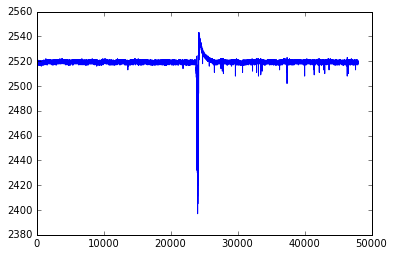

In [25]:
plt.plot(pmtrwf[0,0])

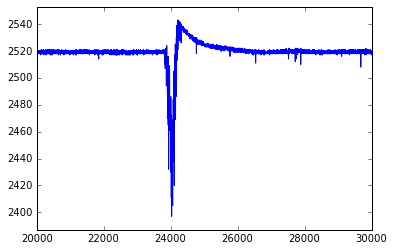

In [26]:
mpl.plts(pmtrwf[0,0], signal_start=20000, signal_end=30000, offset=10)

## Approach 1: thr3 = 1

This approach results in a step at the end of the signal, but the accumulator is stable.

In [27]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,0], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][0], 
                                  coef_blr=dataPMT['coef_blr'][0], 
                                  thr1 = 5, thr2 = 0, thr3=1.0, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2519.0546875 noise (LSB_rms) = 0.756167228828
trigger_line = 3.78083614414 trigger_off = 0.0


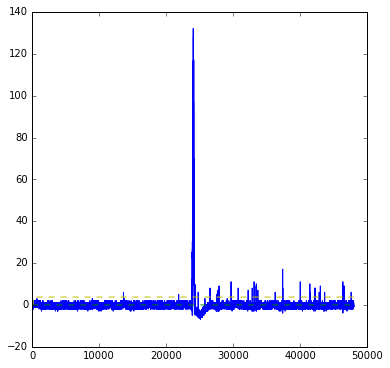

In [28]:
plt.figure(figsize=(6, 6))
xmin=0
xmax=48000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'g--', linewidth=1)

#### S1 likes

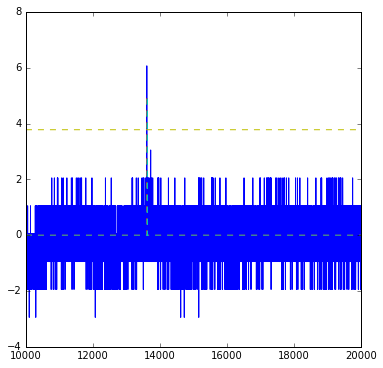

In [29]:
plt.figure(figsize=(6, 6))
xmin=10000
xmax=20000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*5,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*5,'c--', linewidth=1)

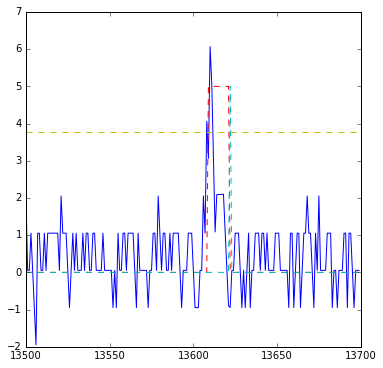

In [30]:
plt.figure(figsize=(6, 6))
xmin=13500
xmax=13700
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*5,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*5,'c--', linewidth=1)

Pulse_on is activated by the S1 above threshold, and switched off as soon as the spike returns to the baseline. Wait_over also switches off immediately since signal_r and signa_daq are identical at this point

### Start of S2

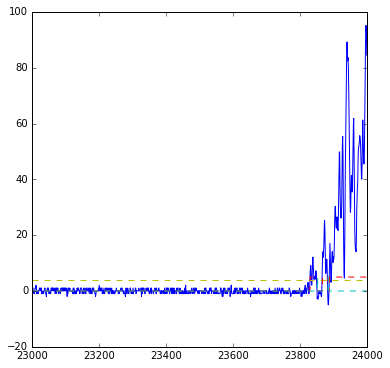

In [31]:
plt.figure(figsize=(6, 6))
xmin=23000
xmax=24000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*5,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*5,'c--', linewidth=1)

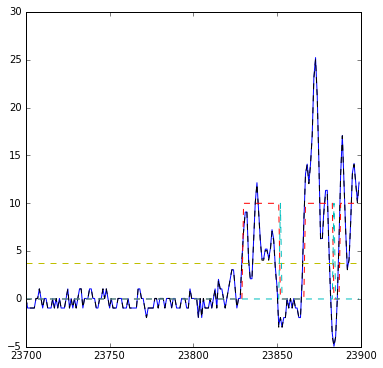

In [32]:
plt.figure(figsize=(6, 6))
xmin=23700
xmax=23900
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*10,'c--', linewidth=1)

pulse_on (wait_over) triggers on and off several times, following the natural fluctuations of the signal. Raw signal and recovered signal are still identical. 

### pulse on =1

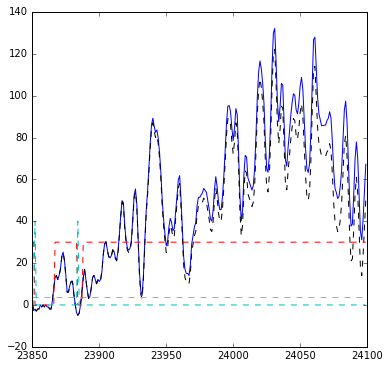

In [33]:
plt.figure(figsize=(6, 6))
xmin=23850
xmax=24100
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*40,'c--', linewidth=1)

Signal has raised aboved threshold and pulse develops. The recovered signal keeps growing above DAQ signal.

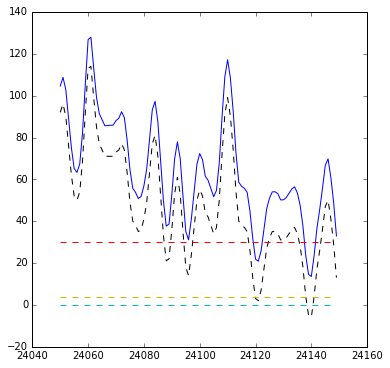

In [34]:
plt.figure(figsize=(6, 6))
xmin=24050
xmax=24150
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*40,'c--', linewidth=1)

### Wait over starts

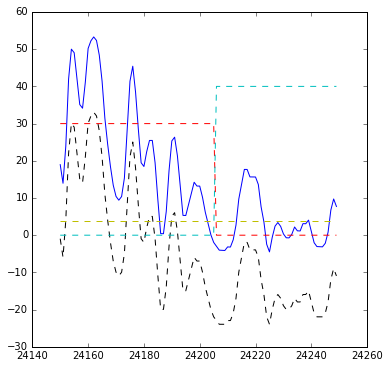

In [35]:
plt.figure(figsize=(6, 6))
xmin=24150
xmax=24250
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*40,'c--', linewidth=1)

The recovered signal crosses threshod and pulse_on switches off. Now the pulse continues recovering until the difference between the recovered signal and the raw signal is less than
~1 noise_rms

### Wait over

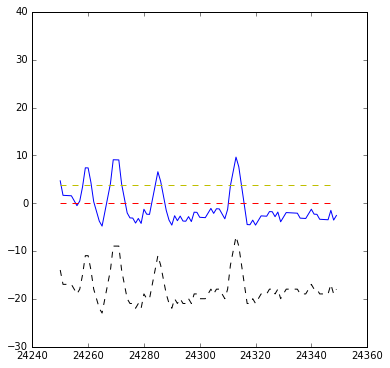

In [36]:
plt.figure(figsize=(6, 6))
xmin=24250
xmax=24350
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*40,'c--', linewidth=1)

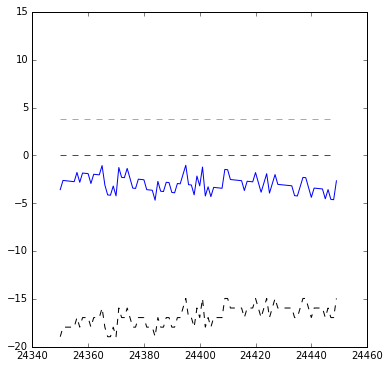

In [37]:
plt.figure(figsize=(6, 6))
xmin=24350
xmax=24450
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*15,'c--', linewidth=1)

As the signal raises well above threshold (no more pulse swich on/off), wait_over is 

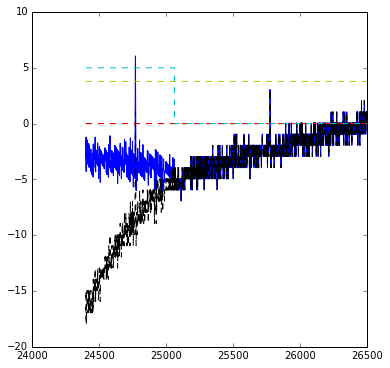

In [38]:
plt.figure(figsize=(6, 6))
xmin = 24400
xmax = 26500
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
#plt.plot(range(xmin,xmax), BLR['MAU'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'g--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*5,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*5,'c--', linewidth=1)
plt.show()

The recovered signal and the daq_signal meet a few counts below threshold, resulting in a step.

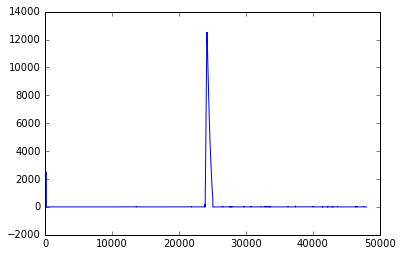

In [39]:
plt.plot(BLR['acum'])

The accumulator is well behaved.

## thr3 < 1

In [40]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,0], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][0], 
                                  coef_blr=dataPMT['coef_blr'][0], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2519.0546875 noise (LSB_rms) = 0.756167228828
trigger_line = 3.78083614414 trigger_off = 0.0


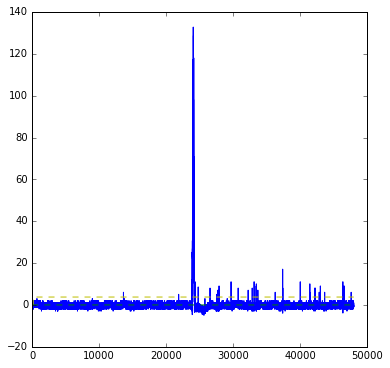

In [41]:
plt.figure(figsize=(6, 6))
xmin=0
xmax=48000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'g--', linewidth=1)

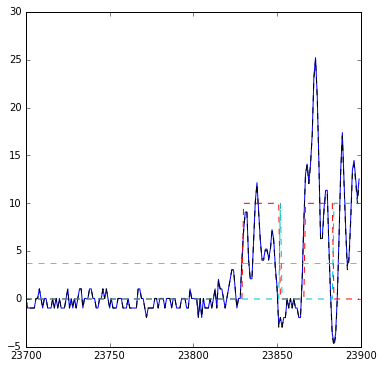

In [42]:
plt.figure(figsize=(6, 6))
xmin=23700
xmax=23900
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*10,'c--', linewidth=1)

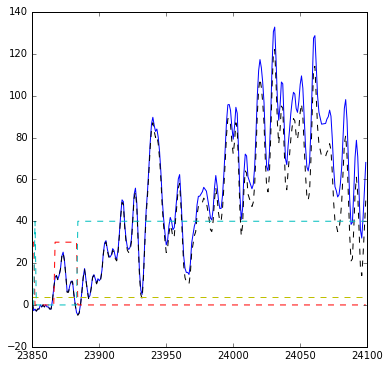

In [43]:
plt.figure(figsize=(6, 6))
xmin=23850
xmax=24100
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*40,'c--', linewidth=1)

Setting th3 low (0.3) results in "cheating the system into recovery mode" from the start of the pulse. 

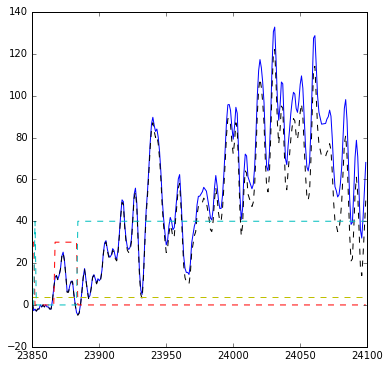

In [44]:
plt.figure(figsize=(6, 6))
xmin=23850
xmax=24100
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*40,'c--', linewidth=1)

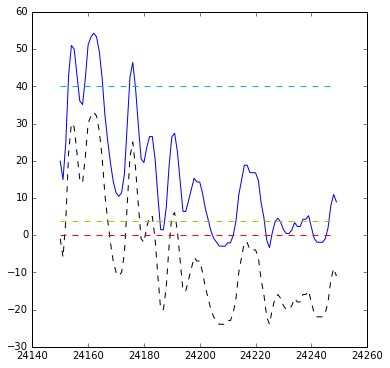

In [45]:
plt.figure(figsize=(6, 6))
xmin=24150
xmax=24250
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*40,'c--', linewidth=1)

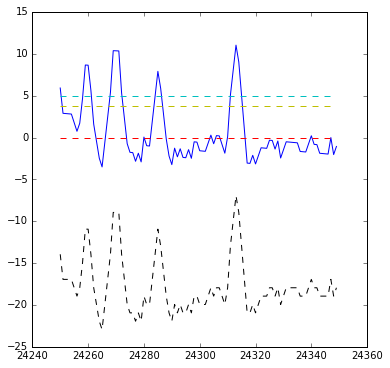

In [46]:
plt.figure(figsize=(6, 6))
xmin=24250
xmax=24350
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*30,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*5,'c--', linewidth=1)

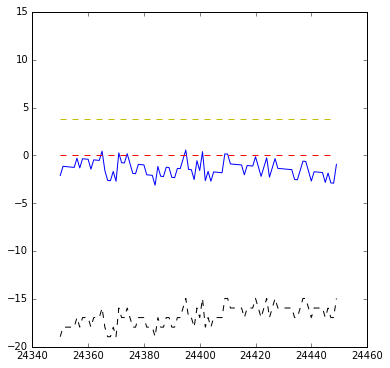

In [47]:
plt.figure(figsize=(6, 6))
xmin=24350
xmax=24450
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*15,'c--', linewidth=1)

recovered signal stays nearer zero

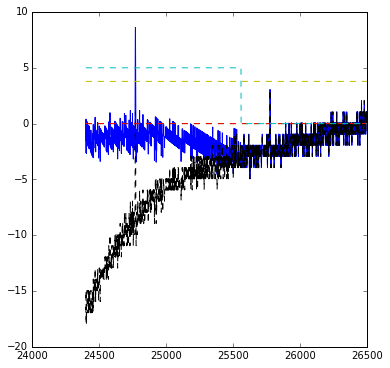

In [48]:
plt.figure(figsize=(6, 6))
xmin = 24400
xmax = 26500
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
#plt.plot(range(xmin,xmax), BLR['MAU'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'g--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*5,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*5,'c--', linewidth=1)
plt.show()

dip occurs later in the waveform (always needed since one has to adjust to raw waveform)

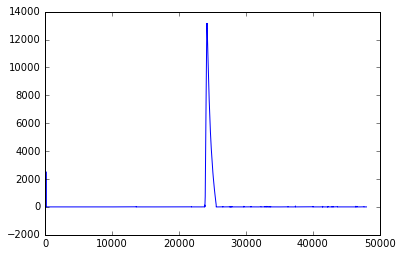

In [49]:
plt.plot(BLR['acum'])

In [50]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,0], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][0], 
                                  coef_blr=dataPMT['coef_blr'][0], 
                                  thr1 = 5, thr2 = 0, thr3=0.1, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2519.0546875 noise (LSB_rms) = 0.756167228828
trigger_line = 3.78083614414 trigger_off = 0.0


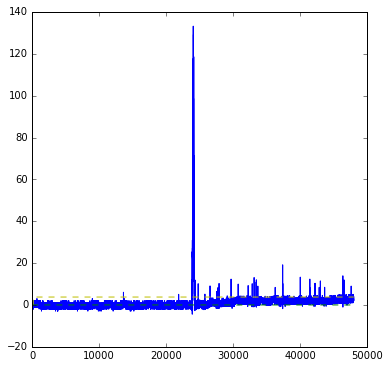

In [51]:
plt.figure(figsize=(6, 6))
xmin=0
xmax=48000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'g--', linewidth=1)

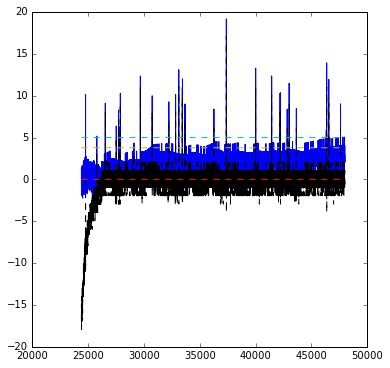

In [52]:
plt.figure(figsize=(6, 6))
xmin = 24400
xmax = 48000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
#plt.plot(range(xmin,xmax), BLR['MAU'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'g--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*5,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*5,'c--', linewidth=1)
plt.show()

always in mode wait over (alwasy recovering)

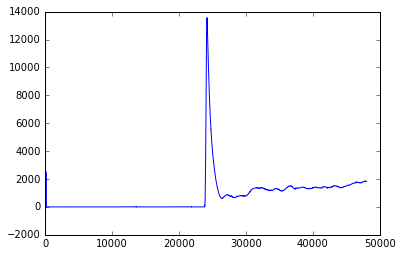

In [53]:
plt.plot(BLR['acum'])

accumlator unstable

In [54]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,0], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][0], 
                                  coef_blr=dataPMT['coef_blr'][0], 
                                  thr1 = 5, thr2 = 0, thr3=0.2, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2519.0546875 noise (LSB_rms) = 0.756167228828
trigger_line = 3.78083614414 trigger_off = 0.0


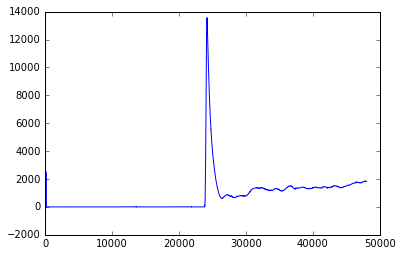

In [55]:
plt.plot(BLR['acum'])

In [56]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,0], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][0], 
                                  coef_blr=dataPMT['coef_blr'][0], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2519.0546875 noise (LSB_rms) = 0.756167228828
trigger_line = 3.78083614414 trigger_off = 0.0


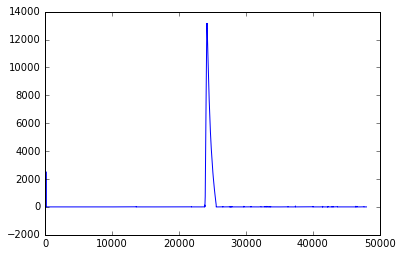

In [57]:
plt.plot(BLR['acum'])

The best value appears to be 0.3

## PMT2

In [58]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,1], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][1], 
                                  coef_blr=dataPMT['coef_blr'][1], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2520.265625 noise (LSB_rms) = 0.757995439705
trigger_line = 3.78997719853 trigger_off = 0.0


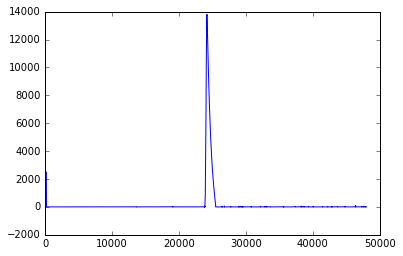

In [59]:
plt.plot(BLR['acum'])

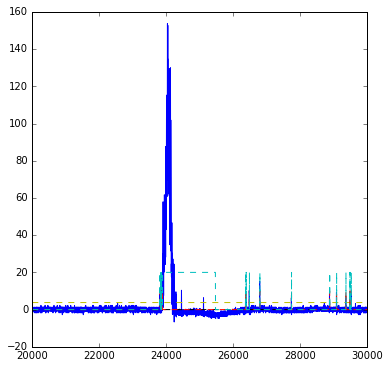

In [60]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT3

In [61]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,2], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][2], 
                                  coef_blr=dataPMT['coef_blr'][2], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2458.828125 noise (LSB_rms) = 0.754089898356
trigger_line = 3.77044949178 trigger_off = 0.0


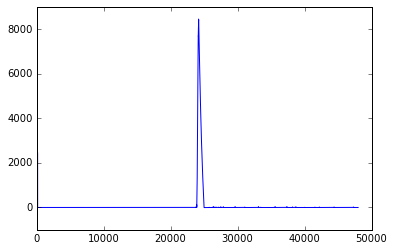

In [62]:
plt.plot(BLR['acum'])

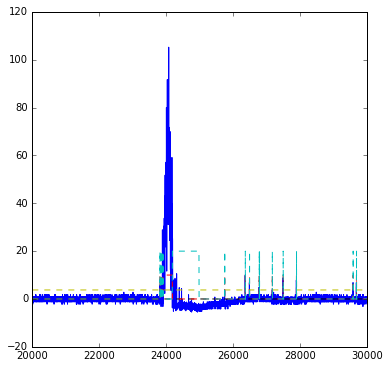

In [63]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT4

In [64]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,3], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][3], 
                                  coef_blr=dataPMT['coef_blr'][3], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2484.609375 noise (LSB_rms) = 0.77596143057
trigger_line = 3.87980715285 trigger_off = 0.0


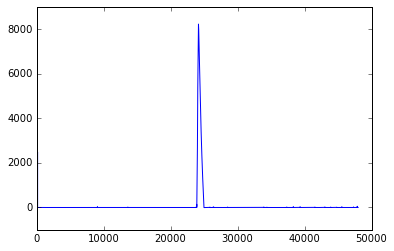

In [65]:
plt.plot(BLR['acum'])

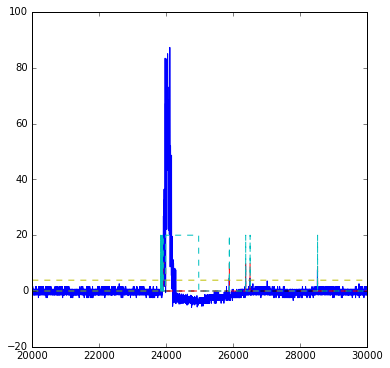

In [66]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT5

In [67]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,4], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][4], 
                                  coef_blr=dataPMT['coef_blr'][4], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2469.8515625 noise (LSB_rms) = 0.794566625304
trigger_line = 3.97283312652 trigger_off = 0.0


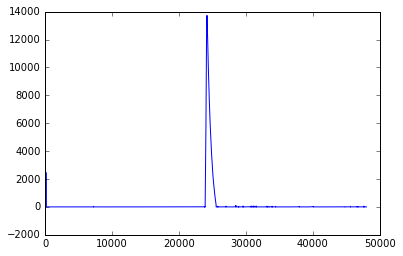

In [68]:
plt.plot(BLR['acum'])

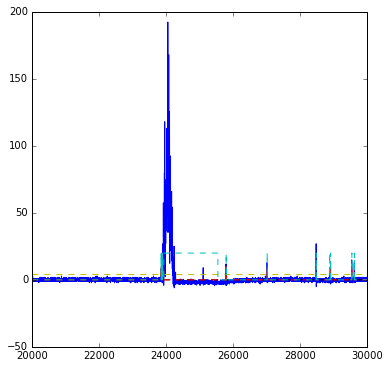

In [69]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT6

In [70]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,5], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][5], 
                                  coef_blr=dataPMT['coef_blr'][5], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2528.4140625 noise (LSB_rms) = 0.808686538359
trigger_line = 4.04343269179 trigger_off = 0.0


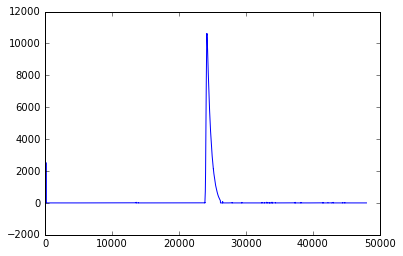

In [71]:
plt.plot(BLR['acum'])

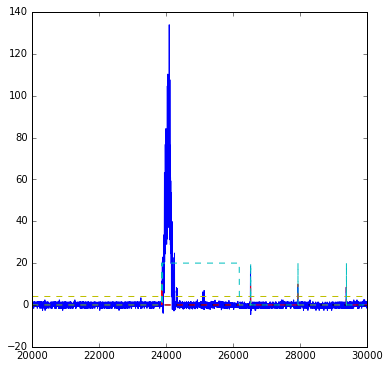

In [72]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT7

In [73]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,6], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][6], 
                                  coef_blr=dataPMT['coef_blr'][6], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2502.7265625 noise (LSB_rms) = 0.760385767718
trigger_line = 3.80192883859 trigger_off = 0.0


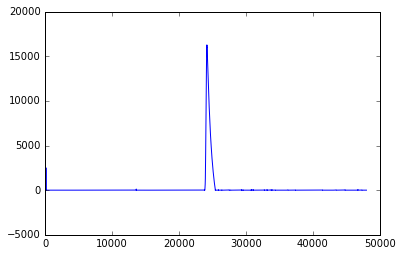

In [74]:
plt.plot(BLR['acum'])

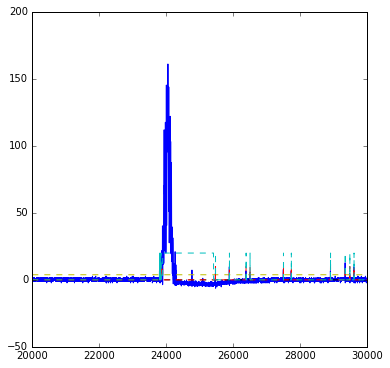

In [75]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT8

In [76]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,7], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][7], 
                                  coef_blr=dataPMT['coef_blr'][7], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2492.5390625 noise (LSB_rms) = 0.719824385298
trigger_line = 3.59912192649 trigger_off = 0.0


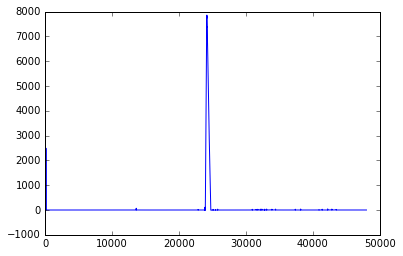

In [77]:
plt.plot(BLR['acum'])

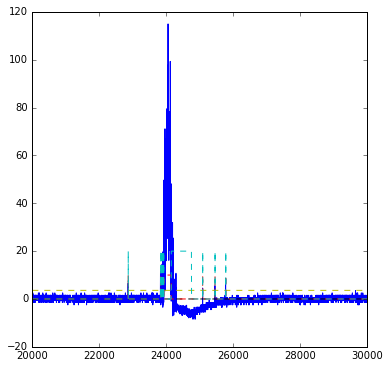

In [78]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT9

In [79]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,8], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][8], 
                                  coef_blr=dataPMT['coef_blr'][8], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2491.328125 noise (LSB_rms) = 0.743574840421
trigger_line = 3.7178742021 trigger_off = 0.0


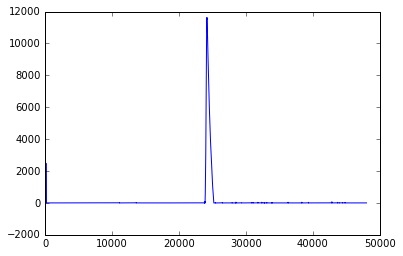

In [80]:
plt.plot(BLR['acum'])

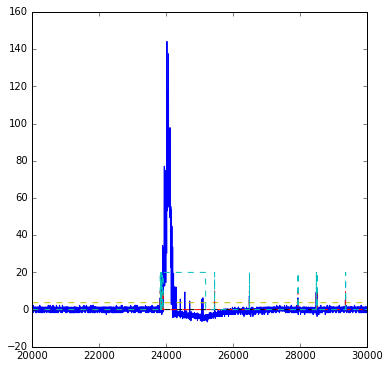

In [81]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT10

In [82]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,9], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][9], 
                                  coef_blr=dataPMT['coef_blr'][9], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2498.890625 noise (LSB_rms) = 0.77596143057
trigger_line = 3.87980715285 trigger_off = 0.0


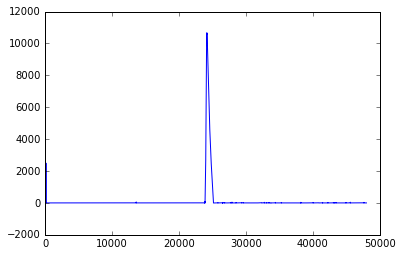

In [83]:
plt.plot(BLR['acum'])

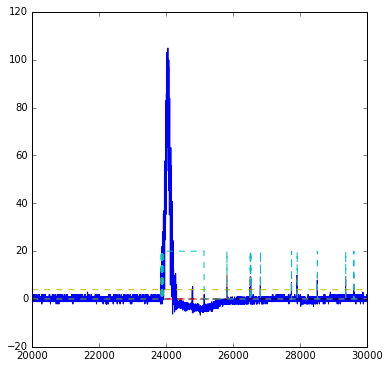

In [84]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT11

In [85]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,10], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][10], 
                                  coef_blr=dataPMT['coef_blr'][10], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2502.1015625 noise (LSB_rms) = 0.730007482973
trigger_line = 3.65003741487 trigger_off = 0.0


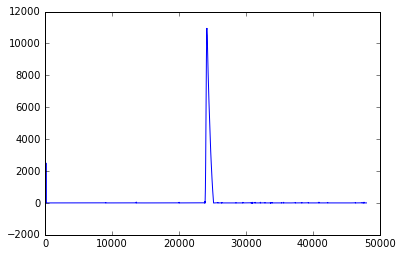

In [86]:
plt.plot(BLR['acum'])

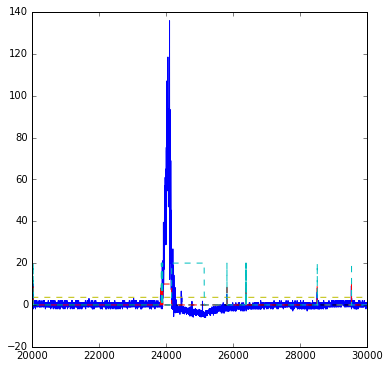

In [87]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## PMT12

In [88]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,11], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][11], 
                                  coef_blr=dataPMT['coef_blr'][11], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2504.6796875 noise (LSB_rms) = 0.720166141702
trigger_line = 3.60083070851 trigger_off = 0.0


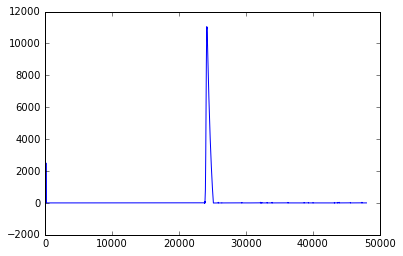

In [89]:
plt.plot(BLR['acum'])

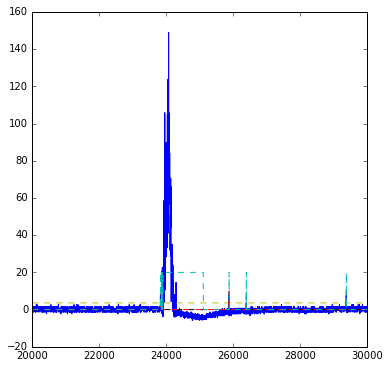

In [90]:
plt.figure(figsize=(6, 6))
xmin=20000
xmax=30000
plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
#plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)

## ACUMULATOR-Controlled algorithm

In [91]:
def deconvolve_signal_acum(signal_daq, n_baseline=500, 
                      coef_clean=2.905447E-06, coef_blr=1.632411E-03, 
                      thr_trigger=5, thr_acum=800, coeff_acum = 0.9995,
                      filter_c=True):

    """
    The accumulator approach by Master VHB

    """
    
    coef = coef_blr
    nm = n_baseline
    
    len_signal_daq = len(signal_daq)
    signal_r = np.zeros(len_signal_daq, dtype=np.double)
    acum = np.zeros(len_signal_daq, dtype=np.double)
    pulse_on = np.zeros(len_signal_daq, dtype=np.int8)
    
    baseline = np.mean(signal_daq[0:nm])
    noise_rms = np.std(signal_daq[0:nm],ddof=1)
    trigger_line =  thr_trigger*noise_rms
    
    #print ("baseline = {} noise (LSB_rms) = {}".format(baseline, noise_rms))
    #print ("trigger line = {} LSB".format(trigger_line))
    
    # change sign and subtract baseline
    signal_daq =  baseline - signal_daq
    
    # clean function
    if filter_c==True:
        b_cf, a_cf = signal.butter(1, coef_clean, 'high', analog=False);
        signal_daq = signal.lfilter(b_cf,a_cf,signal_daq)
 
    # BLR
    signal_r[0:nm] = signal_daq[0:nm] 
    p_on = 0
    
    for k in range(nm,len_signal_daq): 
        pulse_on[k] = p_on
        
        # condition: raw signal raises above trigger line 
        if (signal_daq[k] > trigger_line) or (acum[k-1] > thr_acum):
            if p_on == 0:
                p_on = 1
            # update recovered signal, correcting by offset while acum > thr_acum
            
            signal_r[k] = signal_daq[k] + signal_daq[k]*(coef/2.0) + coef*acum[k-1] 
            acum[k] = acum[k-1] + signal_daq[k] 
                   
        else:
            if p_on == 1:
                p_on = 0
                
            signal_r[k] = signal_daq[k]
            # deplete the accumulator before or after the signal to avoid runoffs
            if (acum[k-1]>0):
                acum[k]=acum[k-1]*coeff_acum
    
    BLR={}
    BLR['acum'] = acum
    BLR['pulse_on'] = pulse_on
    BLR['signal_daq'] = signal_daq
    BLR['signal_r'] = signal_r
    
    return pd.DataFrame(BLR)

In [92]:
signal_r, BLR = deconvolve_signal(pmtrwf[0,0], mau_len=128, 
                                  coef_clean=dataPMT['coef_c'][0], 
                                  coef_blr=dataPMT['coef_blr'][0], 
                                  thr1 = 5, thr2 = 0, thr3=0.3, filter_c=True,
                                  kmin=23850, kmax=23850)

baseline = 2519.0546875 noise (LSB_rms) = 0.756167228828
trigger_line = 3.78083614414 trigger_off = 0.0


In [93]:
BLR = deconvolve_signal_acum(pmtrwf[0,0], n_baseline=500, 
                      coef_clean=dataPMT['coef_c'][0], coef_blr=dataPMT['coef_blr'][0], 
                      thr_trigger=5, thr_acum=800, coeff_acum = 0.9995,
                      filter_c=True)

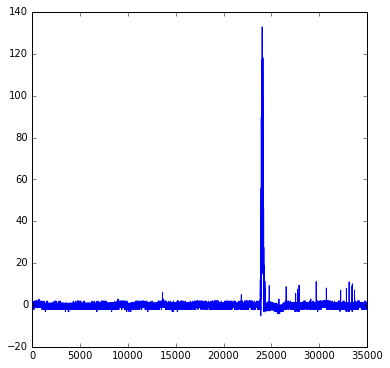

In [94]:
xmin = 0
xmax = 35000
plt.figure(figsize=(6, 6))
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])

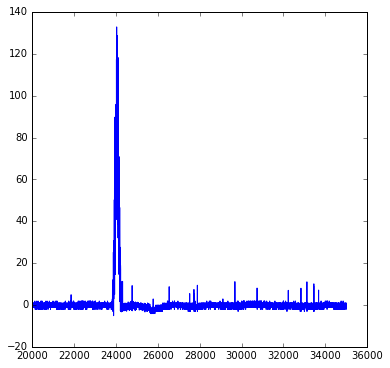

In [95]:
xmin = 20000
xmax = 35000
plt.figure(figsize=(6, 6))
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])

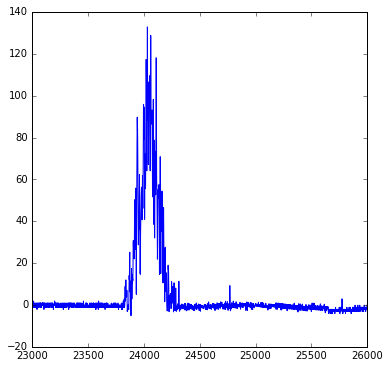

In [96]:
xmin = 23000
xmax = 26000
plt.figure(figsize=(6, 6))
plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])

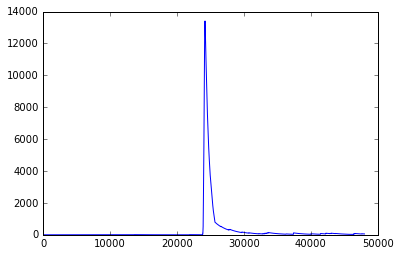

In [97]:
plt.plot(BLR.acum)

In [108]:
def deconv_acum(pmtrwf,dataPMT, thr1 = 5, thr2=800, thr3=0.9995, mau_len=500, 
               xmin=20000,
               xmax=30000, 
               event=0):
    """
    Deconvolution of a full event
    """
    NPMT = pmtrwf.shape[1]
    
    for i in range(NPMT):
        print('PMT number {}'.format(i+1))
        cc = dataPMT['coef_c'][i]
        cblr = dataPMT['coef_blr'][i]
        print('thr1 = {}, thr2 = {}, thr3 = {}, mau length = {}'.format(thr1,thr2, 
                                                                        thr3,mau_len))
        print('deconvoluting PMT = {} with coef_clean = {} coef_blr = {}'.format(i,cc,cblr))
        
        BLR = deconvolve_signal_acum(pmtrwf[event,i], n_baseline=mau_len, 
                      coef_clean=dataPMT['coef_c'][i], coef_blr=dataPMT['coef_blr'][i], 
                      thr_trigger=thr1, thr_acum=thr2, coeff_acum = thr3,
                      filter_c=True)
                                                                            
        
        plt.plot(BLR['acum'])
        plt.show()
        wait()
        plt.figure(figsize=(6, 6))

        plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
        plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
        plt.show()
        wait()
        
    

In [99]:
def deconv_pmt(pmtrwf,dataPMT, thr1 = 5, thr2=0, thr3=0.5, mau_len=128, 
               xmin=20000,
               xmax=30000, 
               event=0):
    """
    Deconvolution of a full event
    """
    NPMT = pmtrwf.shape[1]
    
    for i in range(NPMT):
        print('PMT number {}'.format(i+1))
        cc = dataPMT['coef_c'][i]
        cblr = dataPMT['coef_blr'][i]
        print('thr1 = {}, thr2 = {}, thr3 = {}, mau length = {}'.format(thr1,thr2, 
                                                                        thr3,mau_len))
        print('deconvoluting PMT = {} with coef_clean = {} coef_blr = {}'.format(i,cc,cblr))
                                                                                
        signal_r, BLR = deconvolve_signal(pmtrwf[event,i], 
                                          mau_len=mau_len, 
                                          coef_clean=cc,
                                          coef_blr=cblr, 
                                          thr1 = thr1, 
                                          thr2=thr2, 
                                          thr3=thr3,
                                          filter_c=True)
        
        plt.plot(BLR['acum'])
        plt.show()
        wait()
        plt.figure(figsize=(6, 6))

        plt.plot(range(xmin,xmax),signal_r[xmin:xmax])
        # plt.plot(range(xmin,xmax),BLR['signal_daq'][xmin:xmax],'k--')
        plt.plot(range(xmin,xmax), BLR['trigger_1'][xmin:xmax],'y--', linewidth=1)
        plt.plot(range(xmin,xmax), BLR['trigger_2'][xmin:xmax],'k--', linewidth=1)
        plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
        plt.plot(range(xmin,xmax), BLR['wait_over'][xmin:xmax]*20,'c--', linewidth=1)
        plt.show()
        wait()
        
    

In [100]:
pmtrwf = kr2609.root.RD.pmtrwf

PMT number 1
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 0 with coef_clean = 2.905447e-06 coef_blr = 0.001632411
baseline = 2519.0546875 noise (LSB_rms) = 0.756167228828
trigger_line = 5.29317060179 trigger_off = 0.756167228828


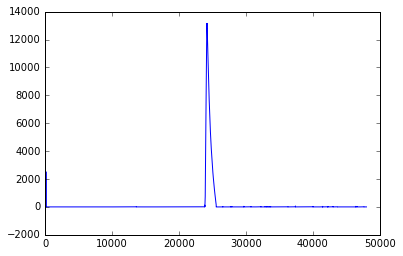

Press a key...


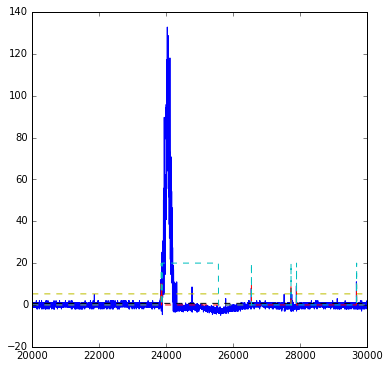

Press a key...
PMT number 2
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 1 with coef_clean = 3.08e-06 coef_blr = 0.001632411
baseline = 2520.265625 noise (LSB_rms) = 0.757995439705
trigger_line = 5.30596807794 trigger_off = 0.757995439705


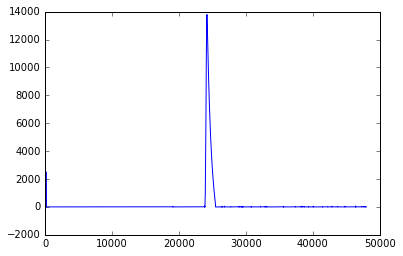

Press a key...


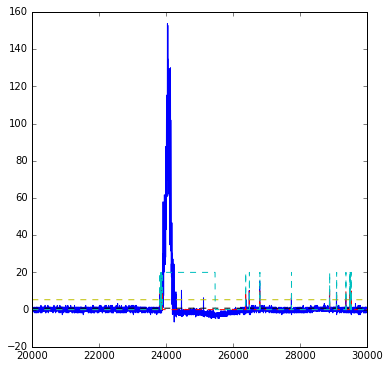

Press a key...
PMT number 3
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 2 with coef_clean = 2.8006e-06 coef_blr = 0.001611104
baseline = 2458.828125 noise (LSB_rms) = 0.754089898356
trigger_line = 5.27862928849 trigger_off = 0.754089898356


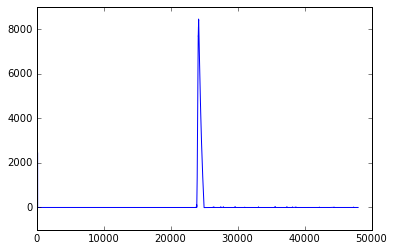

Press a key...


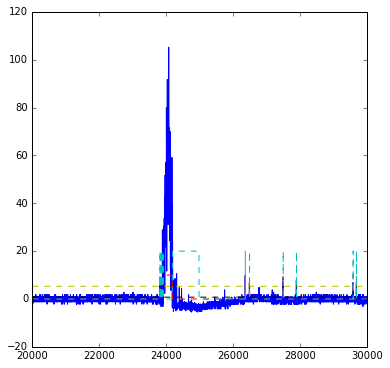

Press a key...
PMT number 4
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 3 with coef_clean = 2.756265e-06 coef_blr = 0.001599356
baseline = 2484.609375 noise (LSB_rms) = 0.77596143057
trigger_line = 5.43173001399 trigger_off = 0.77596143057


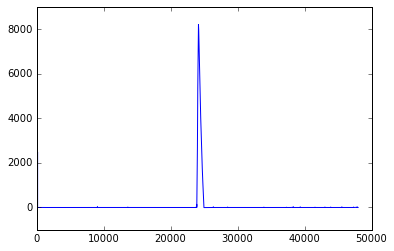

Press a key...


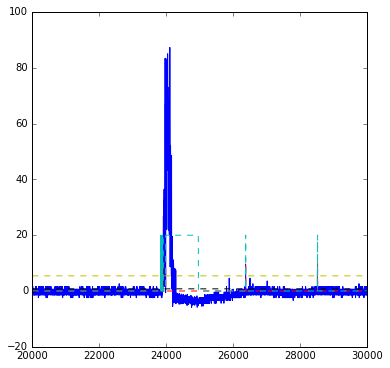

Press a key...
PMT number 5
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 4 with coef_clean = 3.138766e-06 coef_blr = 0.001566958
baseline = 2469.8515625 noise (LSB_rms) = 0.794566625304
trigger_line = 5.56196637713 trigger_off = 0.794566625304


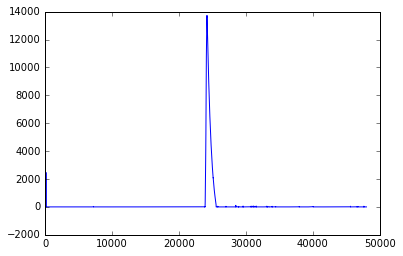

Press a key...


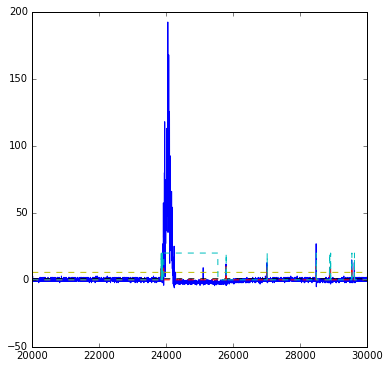

Press a key...
PMT number 6
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 5 with coef_clean = 3.965176e-06 coef_blr = 0.001649618
baseline = 2528.4140625 noise (LSB_rms) = 0.808686538359
trigger_line = 5.66080576851 trigger_off = 0.808686538359


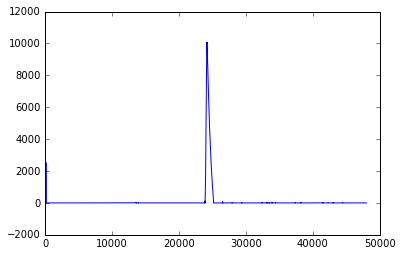

Press a key...


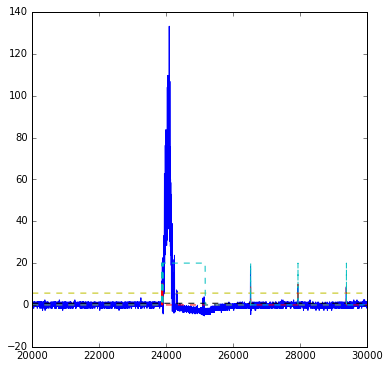

Press a key...
PMT number 7
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 6 with coef_clean = 2.711e-06 coef_blr = 0.001592963
baseline = 2502.7265625 noise (LSB_rms) = 0.760385767718
trigger_line = 5.32270037403 trigger_off = 0.760385767718


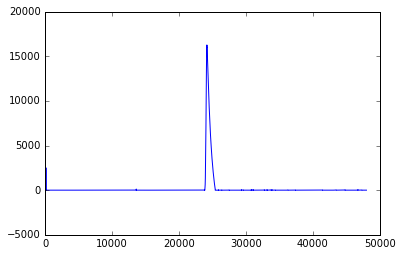

Press a key...


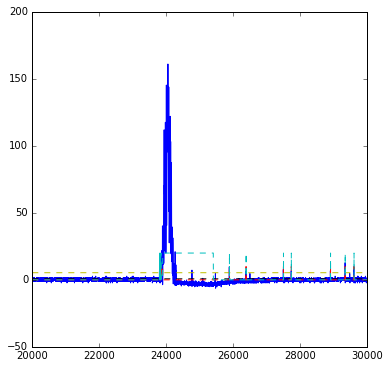

Press a key...
PMT number 8
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 7 with coef_clean = 3.127641e-06 coef_blr = 0.001612068
baseline = 2492.5390625 noise (LSB_rms) = 0.719824385298
trigger_line = 5.03877069708 trigger_off = 0.719824385298


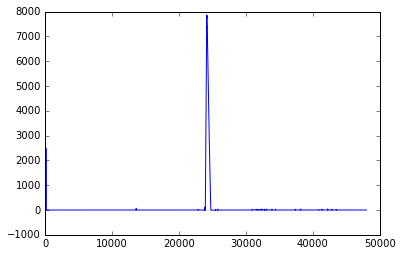

Press a key...


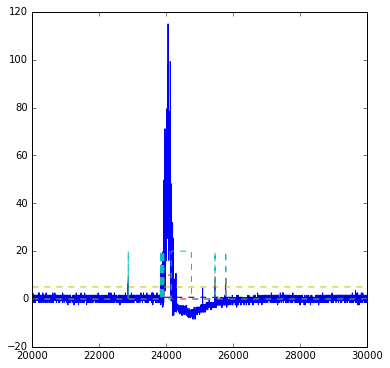

Press a key...
PMT number 9
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 8 with coef_clean = 3.064543e-06 coef_blr = 0.001600683
baseline = 2491.328125 noise (LSB_rms) = 0.743574840421
trigger_line = 5.20502388295 trigger_off = 0.743574840421


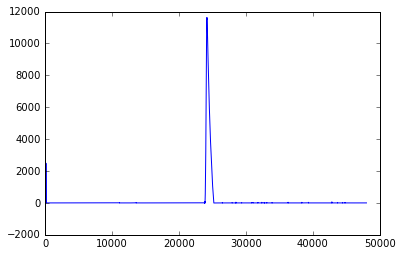

Press a key...


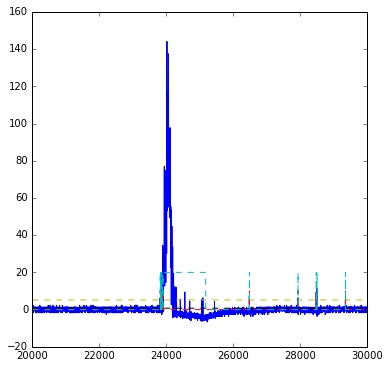

Press a key...
PMT number 10
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 9 with coef_clean = 3.040463e-06 coef_blr = 0.001592718
baseline = 2498.890625 noise (LSB_rms) = 0.77596143057
trigger_line = 5.43173001399 trigger_off = 0.77596143057


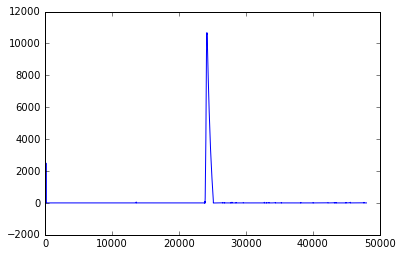

Press a key...


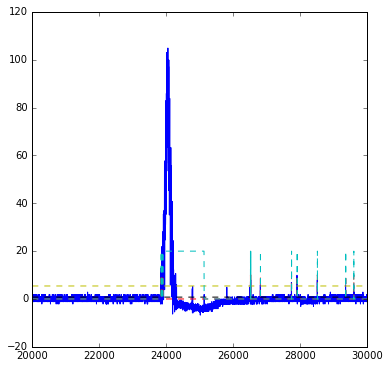

Press a key...
PMT number 11
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 10 with coef_clean = 3.113604e-06 coef_blr = 0.001575192
baseline = 2502.1015625 noise (LSB_rms) = 0.730007482973
trigger_line = 5.11005238081 trigger_off = 0.730007482973


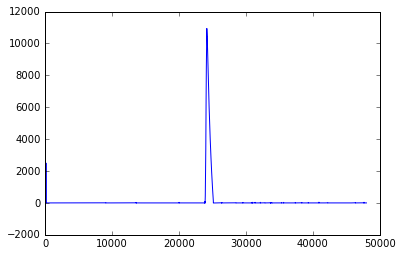

Press a key...


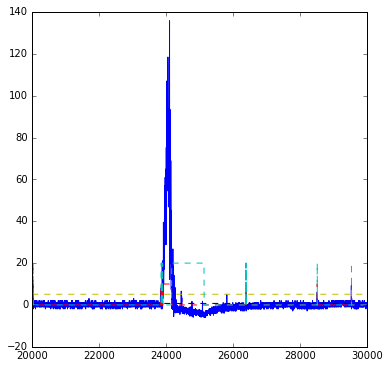

Press a key...
PMT number 12
thr1 = 7, thr2 = 1, thr3 = 0.3, mau length = 128
deconvoluting PMT = 11 with coef_clean = 3.185979e-06 coef_blr = 0.001596322
baseline = 2504.6796875 noise (LSB_rms) = 0.720166141702
trigger_line = 5.04116299191 trigger_off = 0.720166141702


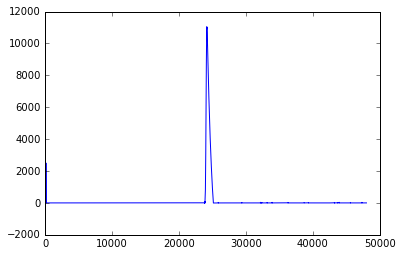

Press a key...


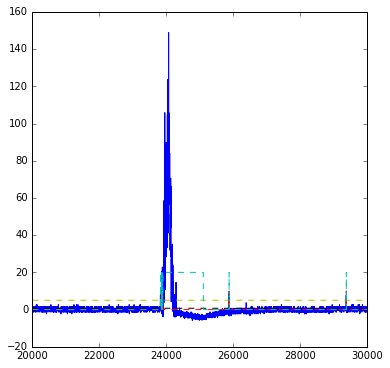

Press a key...


In [101]:
deconv_pmt(pmtrwf,dataPMT, thr1 = 7, thr2=1, thr3=0.3, mau_len=128, 
           xmin=20000,
           xmax=30000, event=0)

In [ ]:
deconv_pmt(pmtrwf,dataPMT, thr1 = 7, thr2=1, thr3=0.5, mau_len=128, 
           xmin=20000,
           xmax=30000, event=0)

In [ ]:
deconv_pmt(pmtrwf,dataPMT, thr1 = 7, thr2=1, thr3=1.0, mau_len=128, 
           xmin=20000,
           xmax=30000, event=0)

The best values for thr3 appear to be 0.3-0.5

### With acumulator controlled

In [102]:
pmtrwf = kr2609.root.RD.pmtrwf

PMT number 1
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 0 with coef_clean = 2.905447e-06 coef_blr = 0.001632411


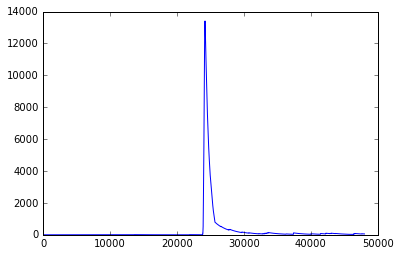

Press a key...


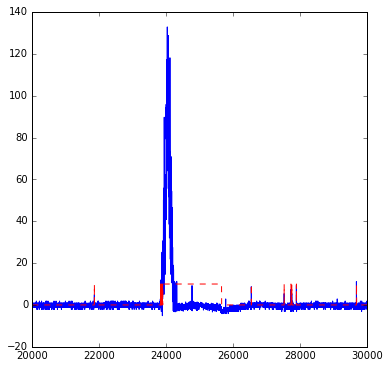

Press a key...
PMT number 2
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 1 with coef_clean = 3.08e-06 coef_blr = 0.001632411


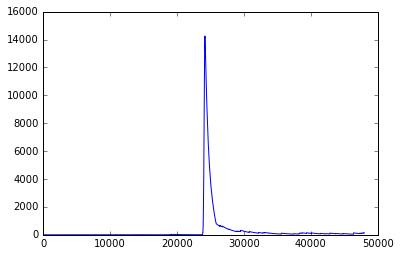

Press a key...


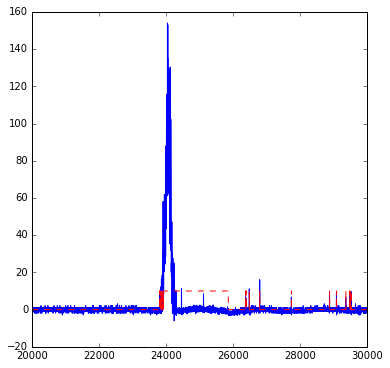

Press a key...
PMT number 3
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 2 with coef_clean = 2.8006e-06 coef_blr = 0.001611104


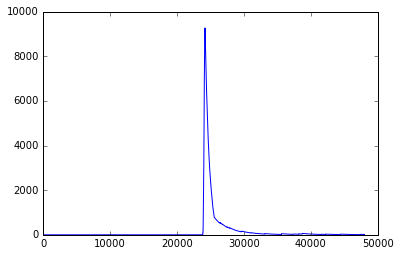

Press a key...


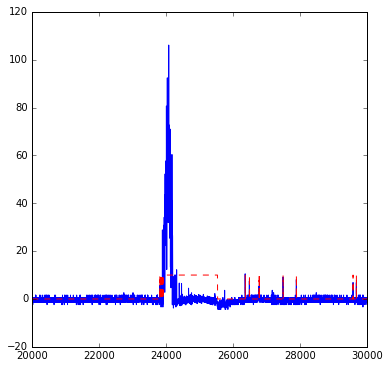

Press a key...
PMT number 4
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 3 with coef_clean = 2.756265e-06 coef_blr = 0.001599356


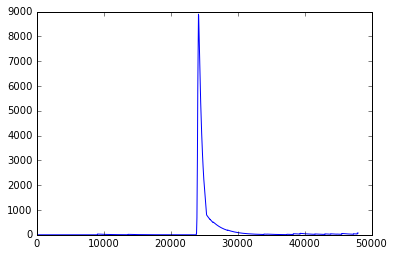

Press a key...


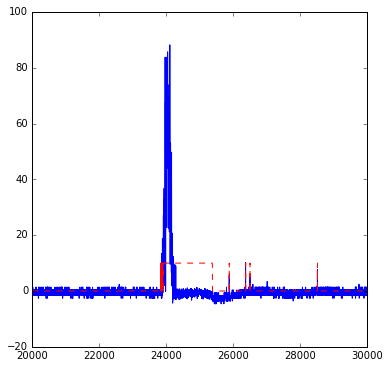

Press a key...
PMT number 5
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 4 with coef_clean = 3.138766e-06 coef_blr = 0.001566958


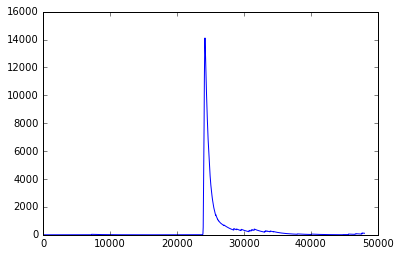

Press a key...


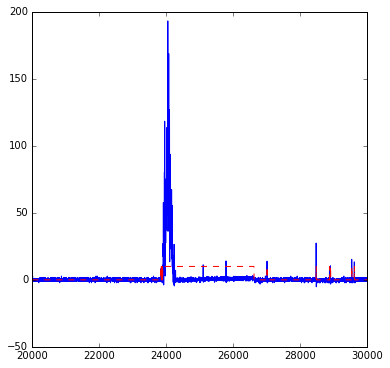

Press a key...
PMT number 6
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 5 with coef_clean = 3.965176e-06 coef_blr = 0.001649618


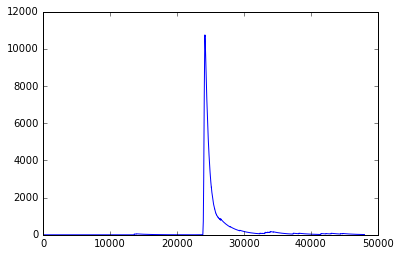

Press a key...


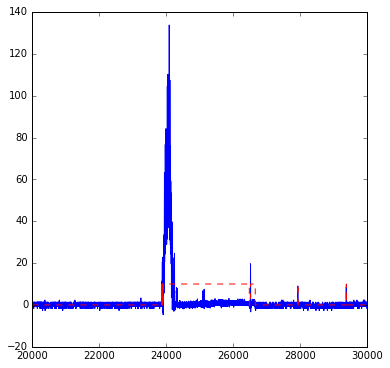

Press a key...
PMT number 7
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 6 with coef_clean = 2.711e-06 coef_blr = 0.001592963


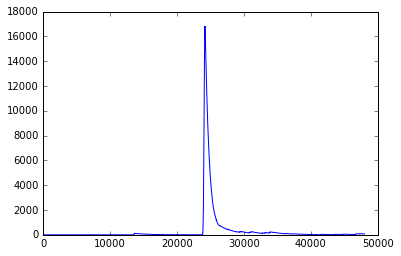

Press a key...


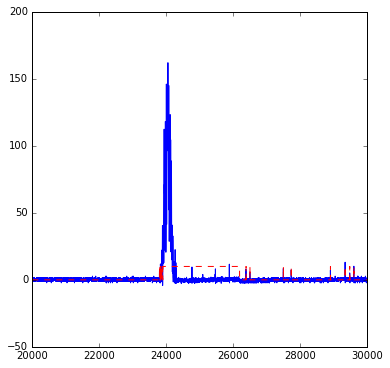

Press a key...
PMT number 8
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 7 with coef_clean = 3.127641e-06 coef_blr = 0.001612068


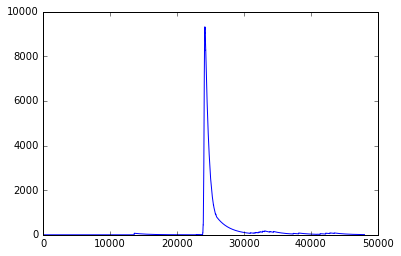

Press a key...


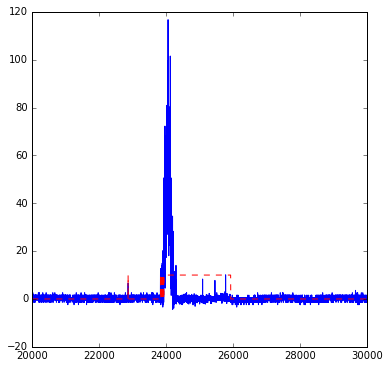

Press a key...
PMT number 9
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 8 with coef_clean = 3.064543e-06 coef_blr = 0.001600683


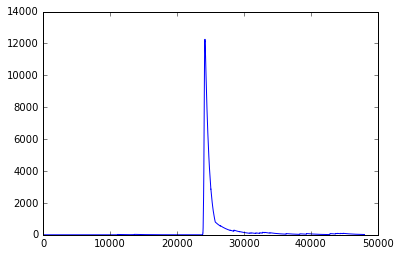

Press a key...


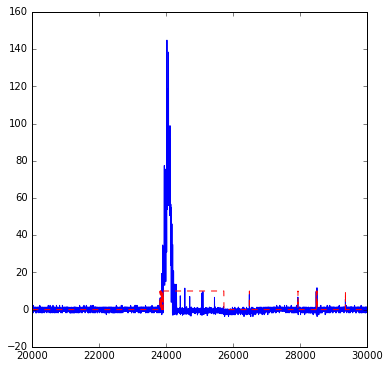

Press a key...
PMT number 10
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 9 with coef_clean = 3.040463e-06 coef_blr = 0.001592718


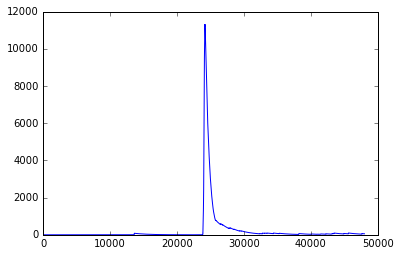

Press a key...


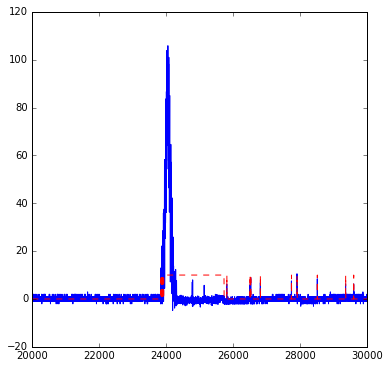

Press a key...
PMT number 11
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 10 with coef_clean = 3.113604e-06 coef_blr = 0.001575192


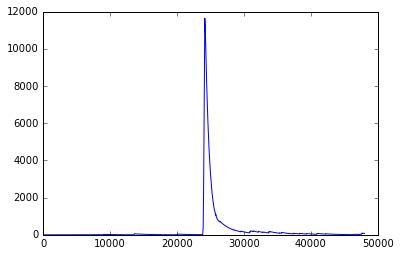

Press a key...


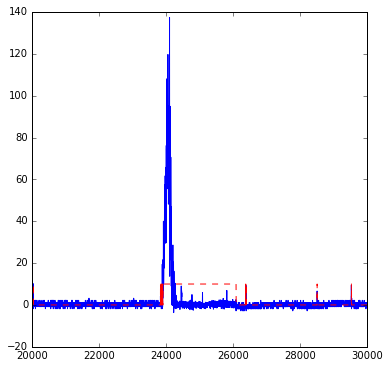

Press a key...
PMT number 12
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 11 with coef_clean = 3.185979e-06 coef_blr = 0.001596322


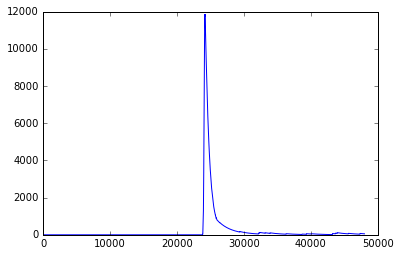

Press a key...


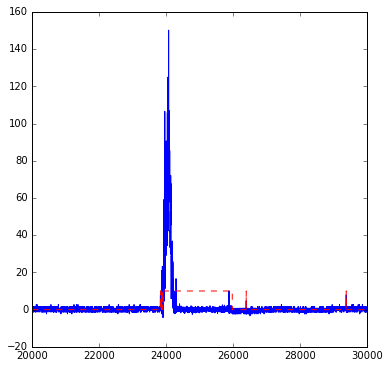

Press a key...


In [103]:
deconv_acum(pmtrwf,dataPMT, thr1 = 5, thr2=800, thr3=0.9995, mau_len=500, 
               xmin=20000,
               xmax=30000, 
               event=0)

#### MUCH BETTER

### Electrons

In [109]:
pmtrwf = e2644.root.RD.pmtrwf

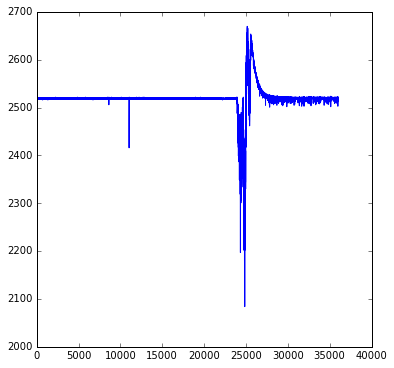

In [110]:
xmin = 0
xmax = 36000
plt.figure(figsize=(6, 6))
plt.plot(range(xmin,xmax),pmtrwf[0,0][xmin:xmax])

PMT number 1
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 0 with coef_clean = 2.905447e-06 coef_blr = 0.001632411


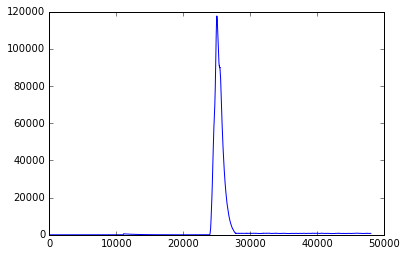

Press a key...


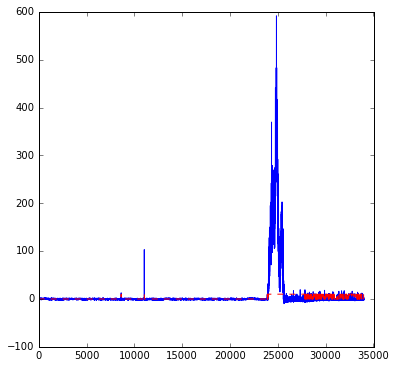

Press a key...
PMT number 2
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 1 with coef_clean = 3.08e-06 coef_blr = 0.001632411


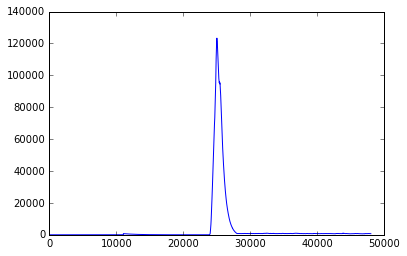

Press a key...


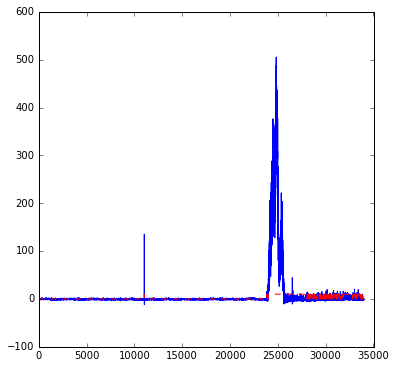

Press a key...
PMT number 3
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 2 with coef_clean = 2.8006e-06 coef_blr = 0.001611104


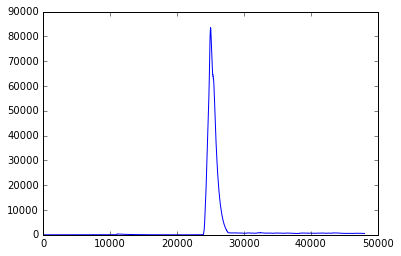

Press a key...


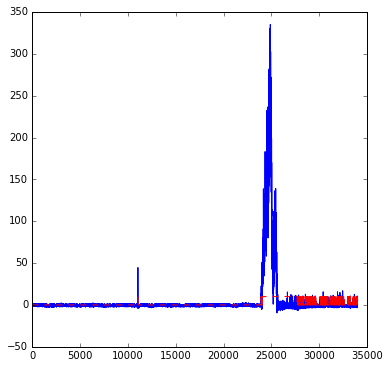

Press a key...
PMT number 4
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 3 with coef_clean = 2.756265e-06 coef_blr = 0.001599356


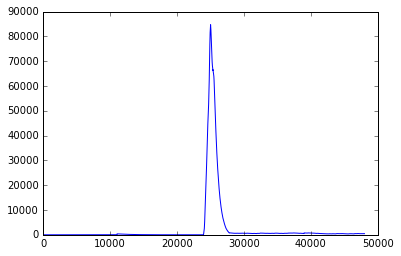

Press a key...


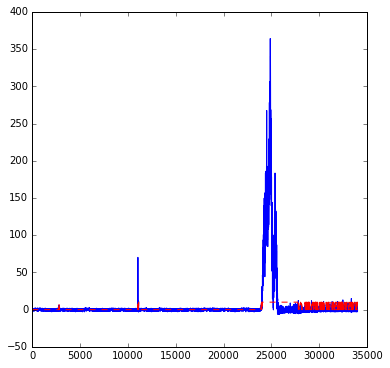

Press a key...
PMT number 5
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 4 with coef_clean = 3.138766e-06 coef_blr = 0.001566958


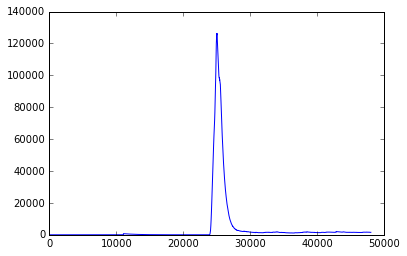

Press a key...


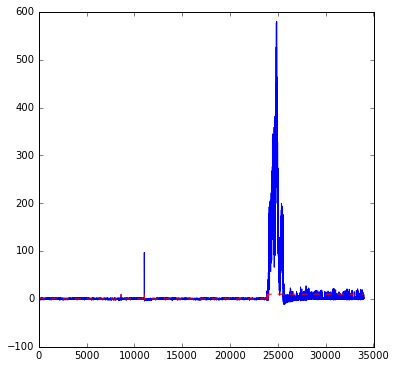

Press a key...
PMT number 6
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 5 with coef_clean = 3.965176e-06 coef_blr = 0.001649618


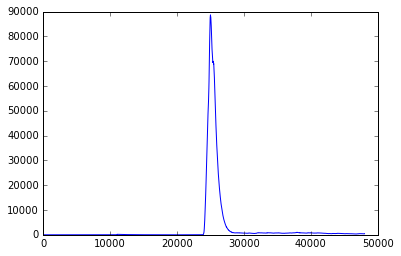

Press a key...


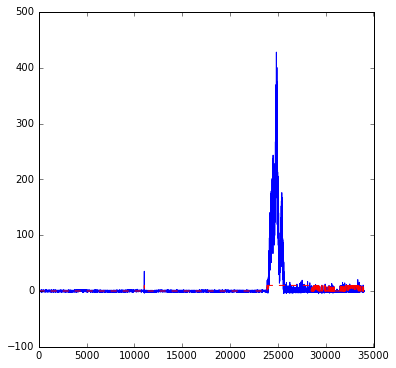

Press a key...
PMT number 7
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 6 with coef_clean = 2.711e-06 coef_blr = 0.001592963


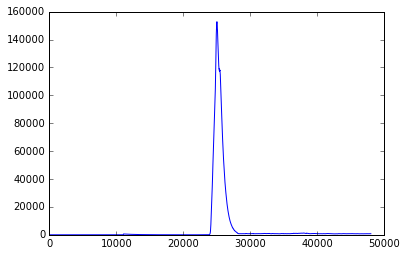

Press a key...


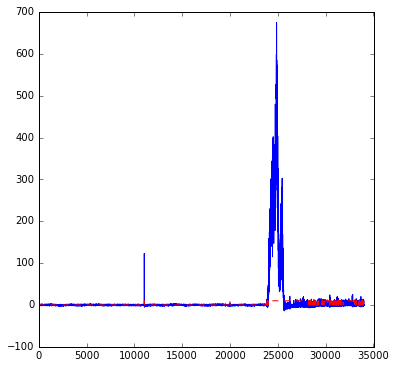

Press a key...
PMT number 8
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 7 with coef_clean = 3.127641e-06 coef_blr = 0.001612068


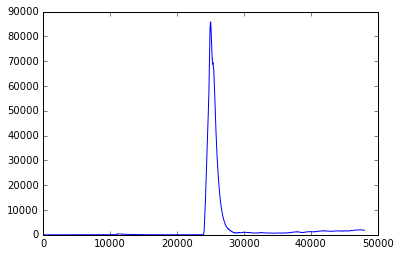

Press a key...


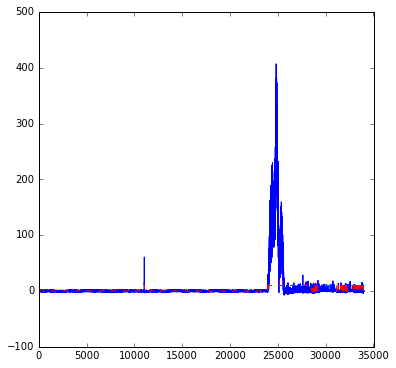

Press a key...
PMT number 9
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 8 with coef_clean = 3.064543e-06 coef_blr = 0.001600683


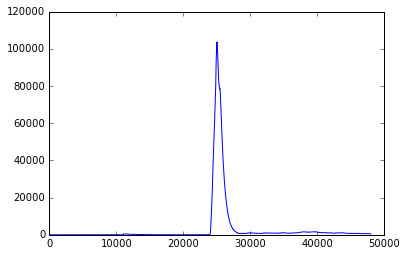

Press a key...


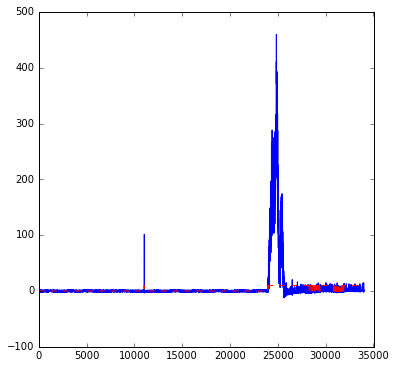

Press a key...
PMT number 10
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 9 with coef_clean = 3.040463e-06 coef_blr = 0.001592718


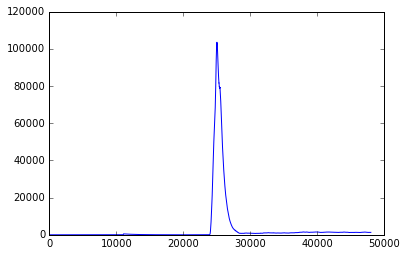

Press a key...


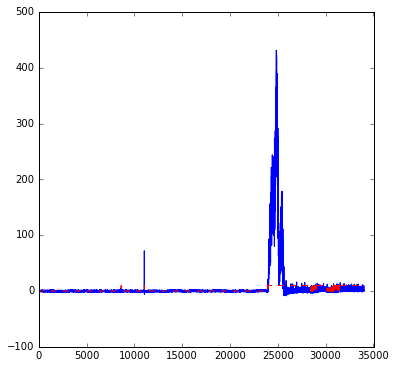

Press a key...
PMT number 11
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 10 with coef_clean = 3.113604e-06 coef_blr = 0.001575192


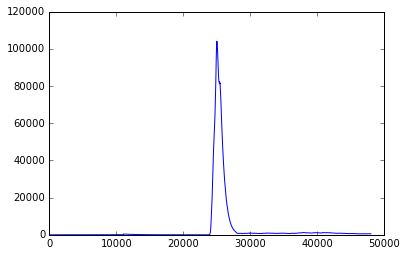

Press a key...


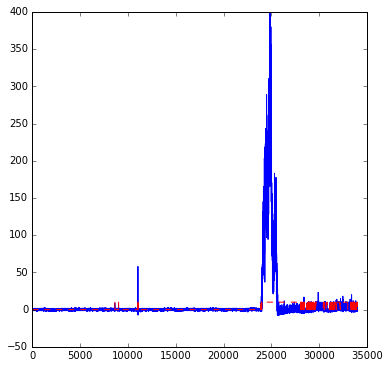

Press a key...
PMT number 12
thr1 = 5, thr2 = 800, thr3 = 0.9995, mau length = 500
deconvoluting PMT = 11 with coef_clean = 3.185979e-06 coef_blr = 0.001596322


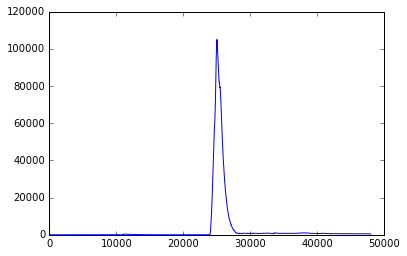

Press a key...


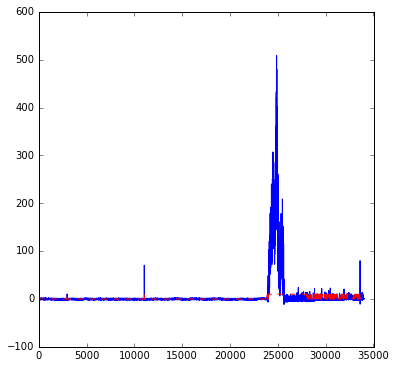

Press a key...


In [111]:
deconv_acum(pmtrwf,dataPMT, thr1 = 5, thr2=800, thr3=0.9995, mau_len=500, 
               xmin=0,
               xmax=34000, 
               event=0)

#### BINGO!

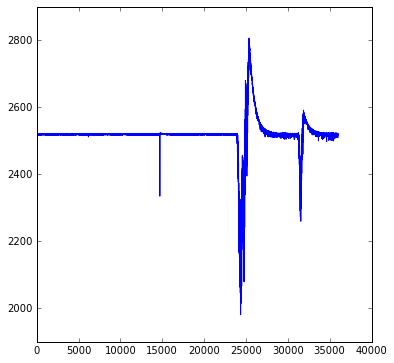

In [107]:
xmin = 0
xmax = 36000
plt.figure(figsize=(6, 6))
plt.plot(range(xmin,xmax),pmtrwf[1,0][xmin:xmax])

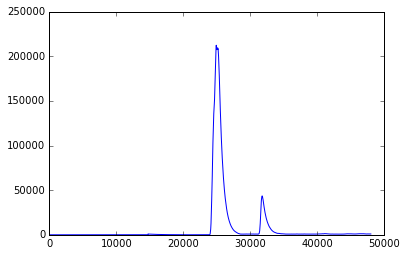

Press a key...


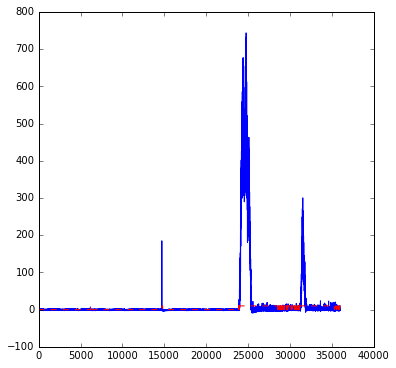

In [ ]:
BLR = deconvolve_signal_acum(pmtrwf[1,0], n_baseline=500, 
                      coef_clean=dataPMT['coef_c'][0], coef_blr=dataPMT['coef_blr'][0], 
                      thr_trigger=5, thr_acum=800, coeff_acum = 0.9995,
                      filter_c=True)
                                                                            
        
plt.plot(BLR['acum'])
plt.show()
wait()
plt.figure(figsize=(6, 6))

plt.plot(range(xmin,xmax),BLR.signal_r[xmin:xmax])
plt.plot(range(xmin,xmax), BLR['pulse_on'][xmin:xmax]*10,'r--', linewidth=1)
plt.show()
wait()